In [3]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#### Create the DataFrame 

In [4]:
codes = {}
codes['US'] = 'USGG10YR'
codes['Germany'] = 'GDBR10'
codes['UK'] = 'GUKG10'
codes['France'] = 'GFRN10'
codes['Australia'] = 'GACGB10'
codes['Canada'] = 'GCAN10YR'
codes['New Zealand'] = 'GNZGB10'
codes['Japan'] = 'JGBS10'
codes['Switzerland'] = 'GSWISS10'
codes['Norway'] = 'GNOR10YR'
codes['Italy'] = 'GBTPGR10'

sheet_names = pd.ExcelFile('G10_RV.xlsx').sheet_names[:11]
dfs = {x: pd.read_excel('G10_RV.xlsx', sheet_name=x)[['Date', 'Last Price']].rename(columns={'Last Price': x}) for x in sheet_names}
df = pd.DataFrame({'Date': dfs[sheet_names[0]]['Date']})  

for key in dfs:
    df = pd.merge(df, dfs[key], on='Date', how='outer')

df = df.set_index('Date').resample('D').asfreq().ffill().dropna()
df.iloc[[0,-1],:]

print(df)

            USGG10YR  GDBR10  GUKG10  GFRN10  GACGB10  GCAN10YR  GNZGB10  \
Date                                                                       
2010-01-05    3.7608   3.373   4.016   3.592    5.621     3.565    5.843   
2010-01-06    3.8215   3.381   4.053   3.607    5.656     3.616    5.790   
2010-01-07    3.8235   3.370   4.052   3.581    5.646     3.637    5.792   
2010-01-08    3.8297   3.385   4.063   3.572    5.681     3.600    5.780   
2010-01-09    3.8297   3.385   4.063   3.572    5.681     3.600    5.780   
...              ...     ...     ...     ...      ...       ...      ...   
2024-04-08    4.4198   2.435   4.085   2.924    4.197     3.625    4.692   
2024-04-09    4.3616   2.371   4.029   2.861    4.173     3.556    4.718   
2024-04-10    4.5435   2.435   4.148   2.926    4.118     3.695    4.638   
2024-04-11    4.5865   2.463   4.201   2.962    4.256     3.730    4.768   
2024-04-12    4.5216   2.359   4.137   2.865    4.266     3.649    4.839   

           

#### XGBoost Model for US Rates 
(Trying to predict the US yield from the yields of the other countries)

In [5]:
def xgboost_model(df):
    ycolumn = "USGG10YR"
    cols = ["GDBR10",	"GUKG10", "GFRN10", "GACGB10", "GCAN10YR","GNZGB10", "JGBS10", "GSWISS10", "GNOR10YR", "GBTPGR10"]
    

    X = df[cols]
    Y = df[ycolumn]
    x_train1, x_valid1, y_train, y_valid = train_test_split(X, Y, train_size=.8, test_size= .2)
    x_train = x_train1[cols].copy()
    x_valid = x_valid1[cols].copy()


    #Pipeline
    numerical_transformer = SimpleImputer(strategy="constant")
    categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
    preprocessor = ColumnTransformer(transformers=[("num", numerical_transformer, cols)])

    # Create Model
    model = XGBRegressor()

    my_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    my_pipeline.fit(x_train, y_train)

    predictions = my_pipeline.predict(x_valid)

    complete_df = pd.concat([y_valid], axis=1)
    complete_df["Predictions"] = predictions
    complete_df["Actual - Prediction"] = (complete_df[ycolumn]  - complete_df["Predictions"])

    print(complete_df)
    

    mae = mean_absolute_error(predictions, y_valid)
    mse = mean_squared_error(predictions, y_valid)
    rsquared = r2_score(predictions, y_valid)

    prediction_df = pd.DataFrame([ycolumn], columns=["Predicted Y"])
    prediction_df["MAE"] = mae
    prediction_df["MSE"] = mse
    prediction_df["R-Square"] = rsquared
    print()
    print()
    print(prediction_df)
    print()
    print()

xgboost_model(df)


            USGG10YR  Predictions  Actual - Prediction
Date                                                  
2020-03-26    0.8447     0.820158             0.024542
2020-07-09    0.6135     0.638595            -0.025095
2019-07-23    2.0812     1.998619             0.082581
2010-11-14    2.7871     2.755920             0.031180
2014-07-18    2.4809     2.485031            -0.004131
...              ...          ...                  ...
2019-07-05    2.0338     2.034819            -0.001019
2018-08-10    2.8732     2.874474            -0.001274
2019-04-03    2.5241     2.507225             0.016875
2018-01-30    2.7199     2.825052            -0.105152
2016-11-04    1.7762     1.785231            -0.009031

[1043 rows x 3 columns]


  Predicted Y       MAE       MSE  R-Square
0    USGG10YR  0.027125  0.001816  0.997689




### New Idea - looking at relative differences in rates over time to see what rates are "undervalued" or "overvalued"


<Axes: xlabel='Date'>

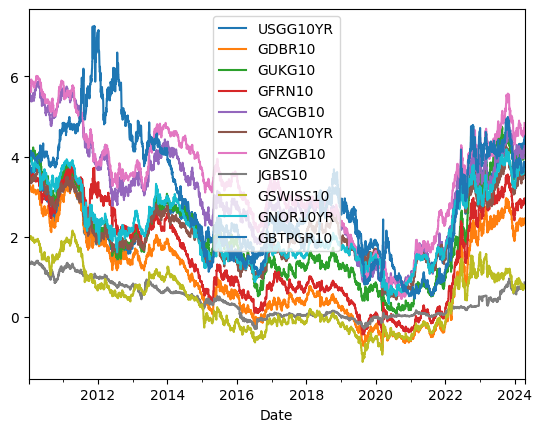

In [6]:
df.plot()

##### Look at the RV value of other rates over the US (ex. Germany Rates / US rates, GB Rates / US rates, etc.)
Clearly there is a change in prior patters during COVID-19

            USGG10YR  GDBR10  GUKG10  GFRN10  GACGB10  GCAN10YR  GNZGB10  \
Date                                                                       
2010-01-05    3.7608   3.373   4.016   3.592    5.621     3.565    5.843   
2010-01-06    3.8215   3.381   4.053   3.607    5.656     3.616    5.790   
2010-01-07    3.8235   3.370   4.052   3.581    5.646     3.637    5.792   
2010-01-08    3.8297   3.385   4.063   3.572    5.681     3.600    5.780   
2010-01-09    3.8297   3.385   4.063   3.572    5.681     3.600    5.780   
...              ...     ...     ...     ...      ...       ...      ...   
2024-04-08    4.4198   2.435   4.085   2.924    4.197     3.625    4.692   
2024-04-09    4.3616   2.371   4.029   2.861    4.173     3.556    4.718   
2024-04-10    4.5435   2.435   4.148   2.926    4.118     3.695    4.638   
2024-04-11    4.5865   2.463   4.201   2.962    4.256     3.730    4.768   
2024-04-12    4.5216   2.359   4.137   2.865    4.266     3.649    4.839   

           

<Axes: xlabel='Date'>

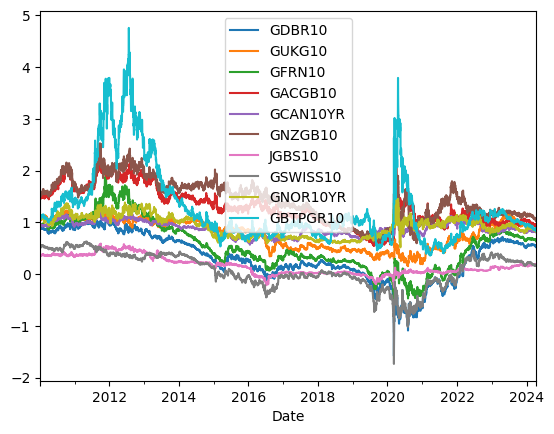

In [43]:
print(df)
USRV_df = df.iloc[:,1:].div(df["USGG10YR"], axis=0)
print(USRV_df)


USRV_df.plot()



In [41]:
mean_list = []
stdev_list = []

list_of_columns = list(df.columns)
list_of_columns = list_of_columns[1:]
print(list_of_columns)

for column in list_of_columns:
    column_mean = USRV_df[column].mean()
    column_std = USRV_df[column].std()
    #print(f"Mean of {column}: {column_mean}")
    #print(f"Standard deviation of {column}: {column_std}")
    mean_list.append(column_mean)
    stdev_list.append(column_std)
    
print(mean_list)
print(stdev_list)

['GDBR10', 'GUKG10', 'GFRN10', 'GACGB10', 'GCAN10YR', 'GNZGB10', 'JGBS10', 'GSWISS10', 'GNOR10YR', 'GBTPGR10']
[0.3284820441339006, 0.7760802865628519, 0.548964785843924, 1.2854189177897792, 0.8748989027815798, 1.4287453375034143, 0.15918906275701097, 0.088040970292272, 0.920591566188948, 1.2707760401642119]
[0.4566357569249711, 0.2781427258981536, 0.47480266358492307, 0.3690439089766718, 0.1307527493814742, 0.3950509507906341, 0.17239680713412547, 0.329092585518395, 0.20235079540549714, 0.7379396287010178]


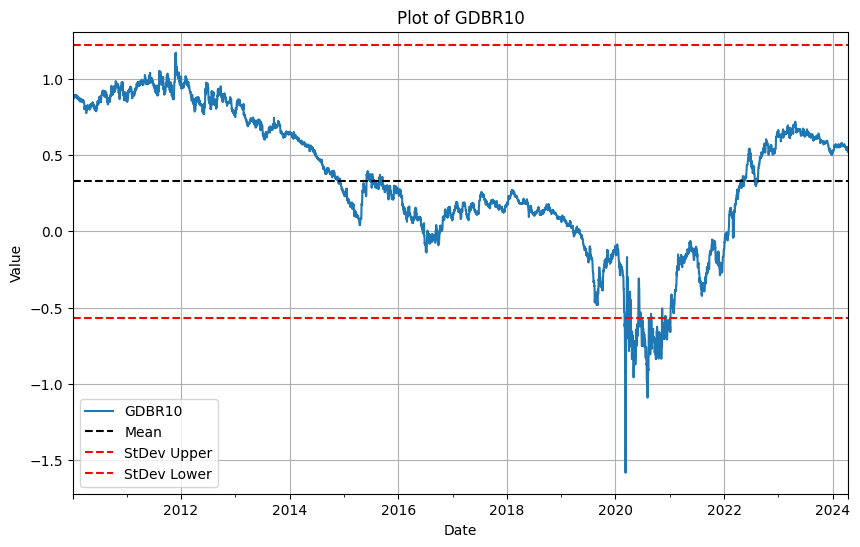

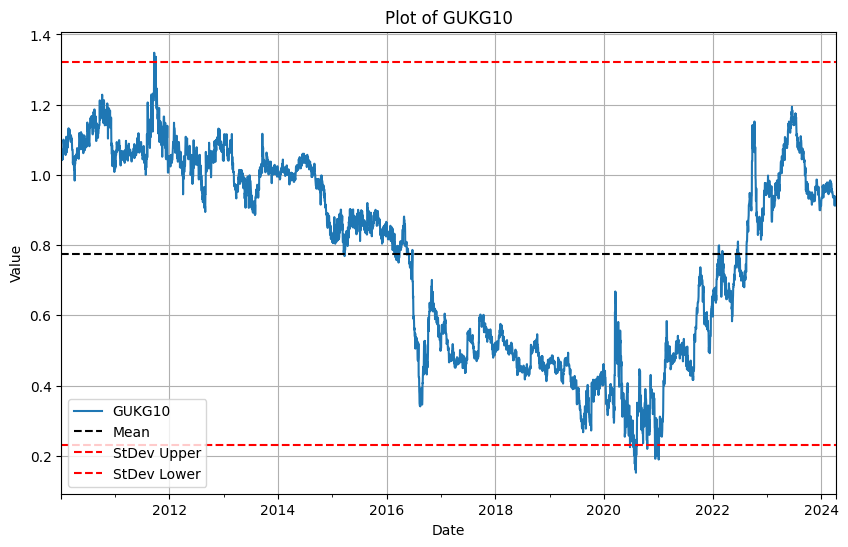

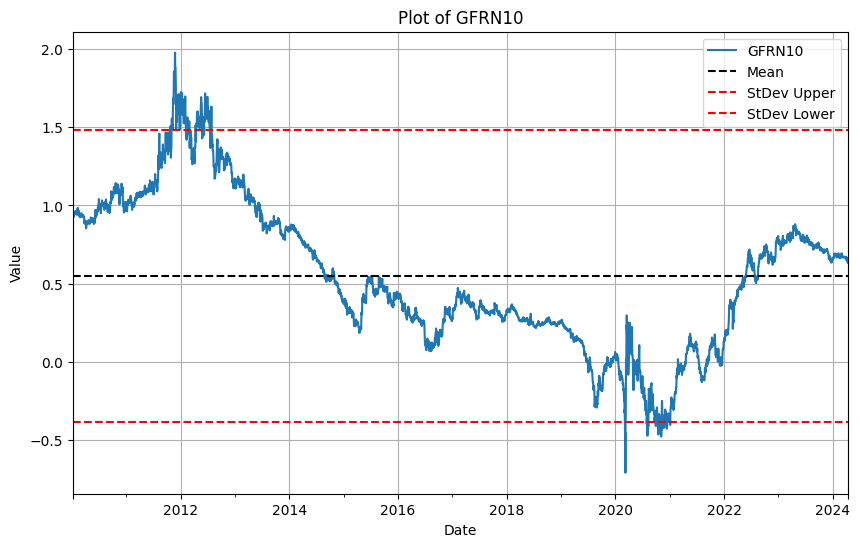

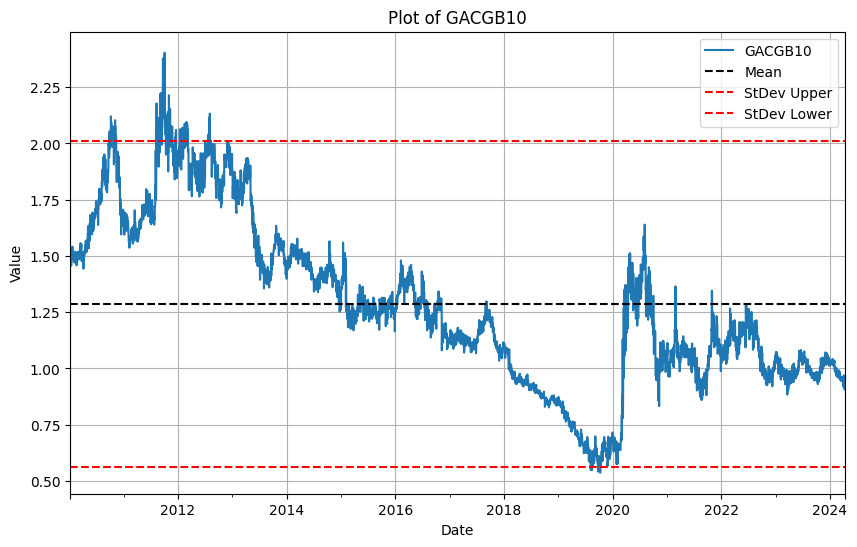

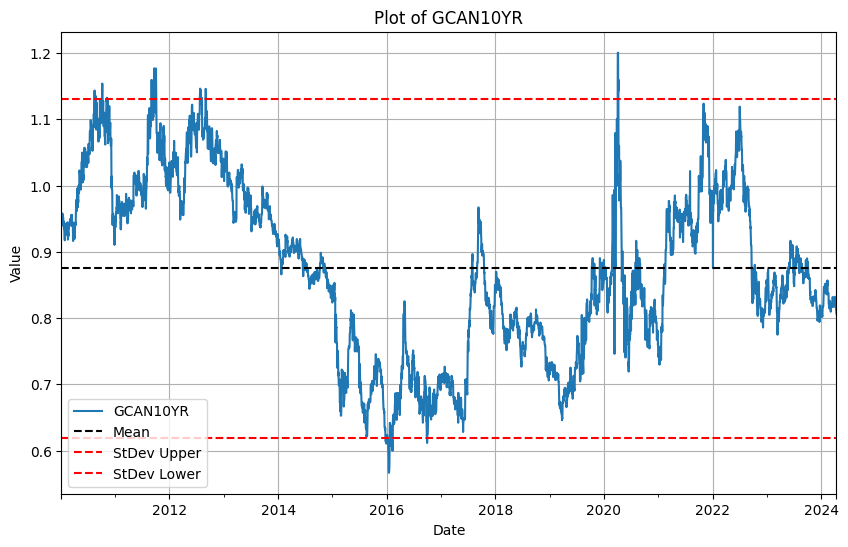

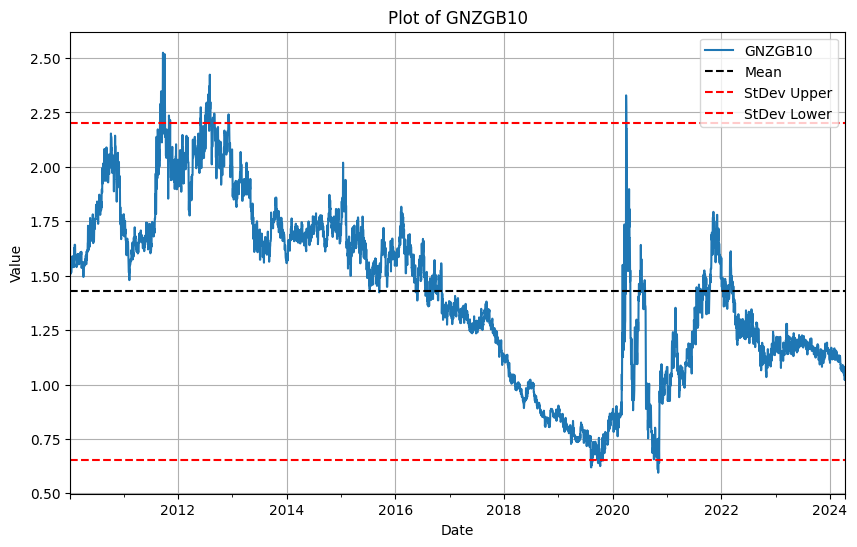

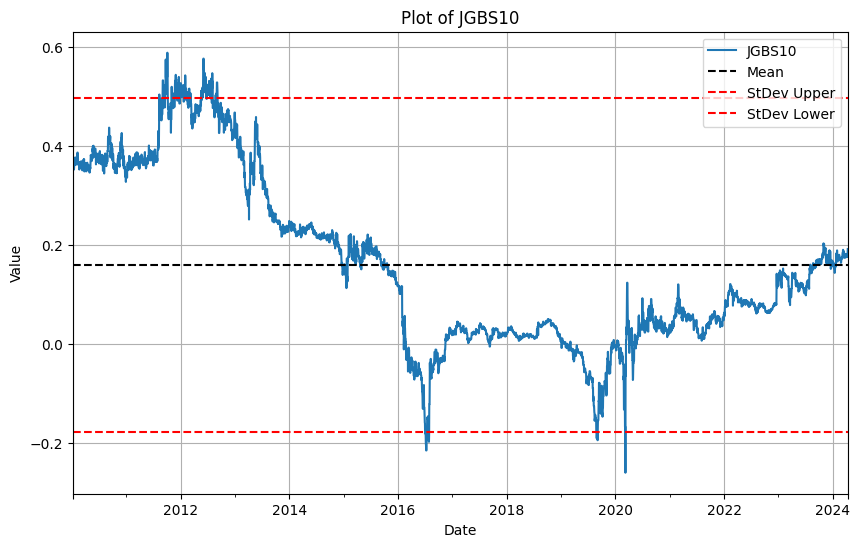

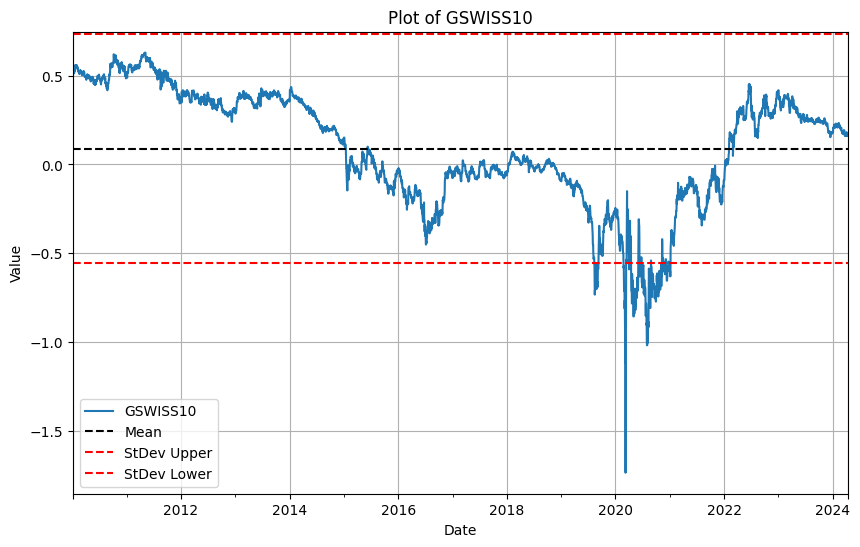

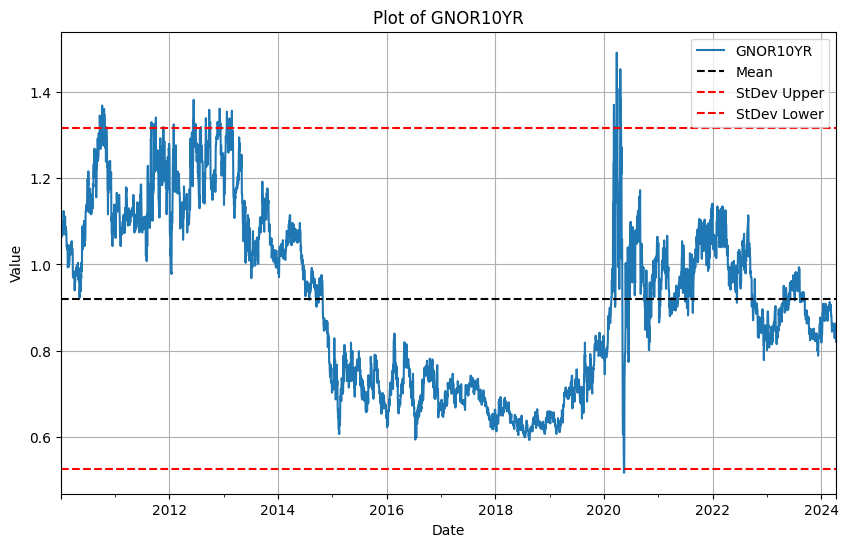

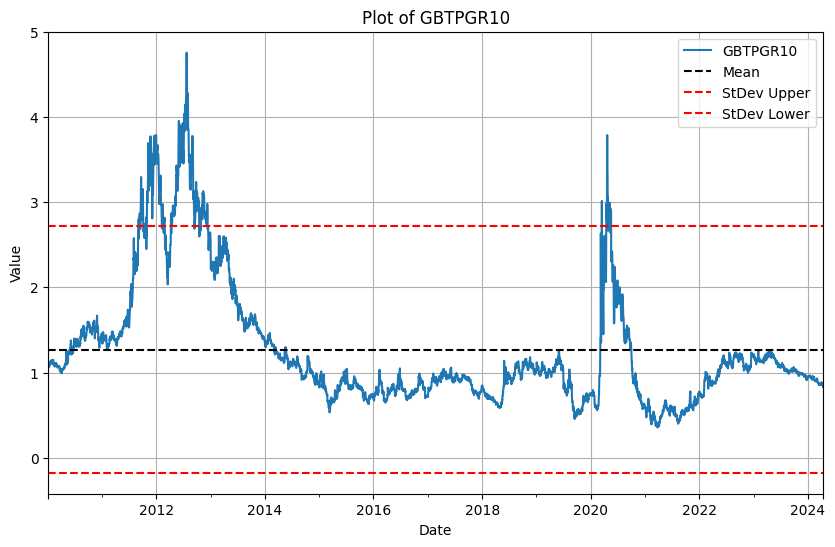

In [44]:


for column, mean, stdev in zip(list_of_columns, mean_list, stdev_list):
    plt.figure(figsize=(10, 6))
    USRV_df[column].plot()
    plt.axhline(mean, color='black', linestyle='--', label='Mean')
    stdev_upper = mean + (stdev * 1.96)
    stdev_lower = mean - (stdev * 1.96)
    plt.axhline(stdev_upper, color='Red', linestyle='--', label='StDev Upper')
    plt.axhline(stdev_lower, color='Red', linestyle='--', label='StDev Lower')

    plt.title(f'Plot of {column}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()